# Power Plot Generation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import squareform, pdist

In [ ]:
def csr(lam, window=[0, 1, 0, 1]):
    """
    An implementation of the completely spatially random point process in a rectangular region. 
    It returns the $x$- and $y$- coordinates of the simulated points.
    """
    
    x_min, x_max, y_min, y_max = window
    area = (y_max-y_min)*(x_max-x_min)
    N = np.random.poisson(lam*area)
    x_list = np.random.uniform(x_min, x_max, N)
    y_list = np.random.uniform(y_min, y_max, N)
    return x_list, y_list

def k_estimate(x, y, window=[0, 1, 0, 1], n=200, r_max=None):
    """
    Estimates the K-function of the input point pattern by Ripley's edge-corrected estimator. 
    It returns an array of values K(r) and the corresponding array of r values.
    """
    
    
    points = np.column_stack((x, y))
    x_min, x_max, y_min, y_max = window
    area = (y_max-y_min)*(x_max-x_min)
    N = len(points)
    lam_hat = N/area
    
    u = squareform(pdist(points)) + np.eye(N)
    d1 = np.minimum(x - x_min, x_max - x)
    d2 = np.minimum(y - y_min, y_max - y)
    d1 = np.tile(d1, (N, 1))
    d2 = np.tile(d2, (N, 1))
    d_hypot = np.hypot(d1, d2)
    
    w1 = 1 - 1/np.pi*(np.arccos(np.minimum(d1, u)/u) + np.arccos(np.minimum(d2, u)/u))
    uu = u.copy()
    uu[uu < d_hypot] = d_hypot[uu < d_hypot]
    w2 = 3/4 - 1/(2*np.pi)*(np.arccos(d1/uu) + np.arccos(d2/uu))
    
    d_hypot = np.hypot(d1, d2)
    w_ind = u <= d_hypot
    w = w_ind*w1 + ~w_ind*w2
    u -= np.eye(N)
    
    if not r_max:
        r_max = min(y_max-y_min, x_max-x_min)/2
    
    r = np.linspace(0, r_max, n)
    k = np.zeros(n)
    for i in range(n):
        d_ind = (u < r[i]) & (u > 0)
        k[i] = np.sum((d_ind/w)/N/lam_hat)
    
    return r, k

In [ ]:
def l_estimate(x, y, **kwargs):
    """
    Estimates the $L$-function of the input point pattern by L(r) = \sqrt(K(r)/pi). 
    It returns an array of values L(r) and the corresponding array of r values.
    """
    r, k = k_estimate(x, y, **kwargs)
    l = np.sqrt(k/np.pi)
    return r, l

def sup_L_r(x, y, **kwargs):
    """
    Compute T = sup|L(r) - r| for r < r_max.
    """
    r, l = l_estimate(x, y, **kwargs)
    return abs(max(l - r, key=abs))

def csr_critical_value(x, y, window=[0, 1, 0, 1], alpha=0.05, nsim=99, **kwargs):
    x_min, x_max, y_min, y_max = window
    area = (y_max-y_min) * (x_max-x_min)
    lam_hat = len(x)/area
    
    l_stats = np.zeros(nsim)
    
    for i in range(nsim):
        xx, yy = csr(lam_hat, window=window)
        sup_l = sup_L_r(xx, yy)
        l_stats[i] = sup_l
    
    return np.quantile(l_stats, 1-alpha)

def csr_test(x, y, window=[0, 1, 0, 1], alpha=0.05, nsim=99):
    c = csr_critical_value(x, y, window, alpha, nsim)
    t = sup_L_r(x, y)
    return t < c

In [ ]:
def thomas_process(rho_centre = 10, 
                   mu_cluster = 100, 
                   sigma = 0.05, 
                   boundary=[0, 1, 0, 1]):

    # Simulation window parameters
    xMin = boundary[0];
    xMax = boundary[1];
    yMin = boundary[2];
    yMax = boundary[3];

    # Extended simulation windows parameters
    rExt=6*sigma; # extension parameter 
    # for rExt, use factor of deviation sigma eg 5 or 6
    xMinExt = xMin - rExt;
    xMaxExt = xMax + rExt;
    yMinExt = yMin - rExt;
    yMaxExt = yMax + rExt;
    # rectangle dimensions
    xDeltaExt = xMaxExt - xMinExt;
    yDeltaExt = yMaxExt - yMinExt;
    areaTotalExt = xDeltaExt * yDeltaExt;  # area of extended rectangle

    # Simulate Poisson point process for the parents
    numbPointsParent = np.random.poisson(areaTotalExt * rho_centre);# Poisson number of points
    # x and y coordinates of Poisson points for the parent
    xxParent = xMinExt + xDeltaExt * np.random.uniform(0, 1, numbPointsParent);
    yyParent = yMinExt + yDeltaExt * np.random.uniform(0, 1, numbPointsParent);

    # Simulate Poisson point process for the daughters (ie final poiint process)
    numbPointsDaughter = np.random.poisson(mu_cluster, numbPointsParent);
    numbPoints = sum(numbPointsDaughter);  # total number of points

    # Generate the (relative) locations in Cartesian coordinates by
    # simulating independent normal variables
    xx0 = np.random.normal(0, sigma, numbPoints);  # (relative) x coordinaets
    yy0 = np.random.normal(0, sigma, numbPoints);  # (relative) y coordinates

    # replicate parent points (ie centres of disks/clusters)
    xx = np.repeat(xxParent, numbPointsDaughter);
    yy = np.repeat(yyParent, numbPointsDaughter);

    # translate points (ie parents points are the centres of cluster disks)
    xx = xx + xx0;
    yy = yy + yy0;

    # thin points if outside the simulation window
    booleInside = ((xx >= xMin) & (xx <= xMax) & (yy >= yMin) & (yy <= yMax));
    # retain points inside simulation window
    xx = xx[booleInside];  
    yy = yy[booleInside];
    return xx, yy

# this was the code taken directly from created H. Paul Keeler 

$\text{Keeler H.P.} \hspace{2mm}\textit{Simulating a Thomas cluster point process}. \text{Available from}$ https://hpaulkeeler.com/simulating-a-thomas-cluster-point-process/ $\text{[Accessed 14th June 2021]}$

In [ ]:
# for each sigma we simulated 1000 different thomas processes with 
# rho = 5, mu = 20 on a 1*1 window
# hypothesis tests have a 5% confidence
sigmas_t = [0.1, 0.125, 0.15, 0.175, 0.2, 
            0.25, 0.3, 0.4, 0.5, 0.6, 0.7]
powers_t = []
for sigma in sigmas_t:
    results = []
    for i in range(1000):
        obs = thomas_process(rho_centre = 5, 
                             mu_cluster = 20, 
                             sigma = sigma, 
                             boundary=[0, 1, 0, 1])
        x, y = obs
        results.append(csr_test(x, y))
    power_t.append((1000 - sum(results))/10)

In [2]:
# the output of my simulation
powers_t = [99.4, 98.0, 92.4, 81.9, 69.4, 
            42.7, 32.2, 11.8, 7.5, 5.8, 6.1]
sigmas_t = [0.1, 0.125, 0.15, 0.175, 0.2, 
            0.25, 0.3, 0.4, 0.5, 0.6, 0.7]

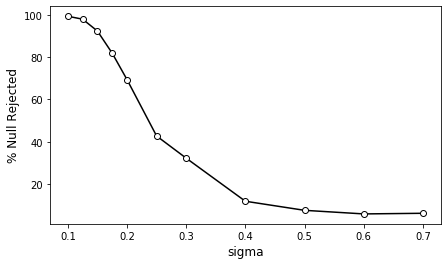

In [3]:
plt.figure(figsize=(7, 4))
plt.plot(sigmas_t, powers_t, marker='o', mfc='white', ls='-', c='k')
plt.xlabel('sigma', fontsize=12)
plt.ylabel('% Null Rejected', fontsize=12)
plt.savefig('tom-power.png', dpi=300, bbox_inches='tight')